#Define objective/goal
classification process using a Deep Learning framework
##Source of data
The data is given and we have no clue on the source and nature of the data.

We’ll start with a bunch of imports and setting a random seed for reproducibility:

##imports we need for the learning and the entire process

In [78]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
#from keras.utils import np_utils
#from sklearn.preprocessing import LabelEncoder

RANDOM_SEED = 7

#Reading the input

We have a button for uploading the data, we dont provide a link to the data for privacy and security reasons

In [8]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [9]:
data=pd.read_csv('dataset.csv', header=0)
data = data.dropna()
print(data.shape)
print(list(data.columns))

(48097, 6)
['0', '1', '2', '3', '4', 'label']


So we have enough data to train

In [10]:
data.head()

,0,1,2,3,4,label
0,122.254980,-316.232650,-51.128054,-556.887773,-49.236176,5
1,-58.995946,393.699146,-161.999853,529.245672,-313.172495,4
2,-796.965065,-607.421427,295.521428,109.111587,25.661300,1
3,185.968028,223.865456,595.139067,17.734789,339.045266,2
4,-730.487099,-162.005114,-237.058238,85.692674,-149.535557,1


#Data Pre-processing

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48097 entries, 0 to 48096
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       48097 non-null  float64
 1   1       48097 non-null  float64
 2   2       48097 non-null  float64
 3   3       48097 non-null  float64
 4   4       48097 non-null  float64
 5   label   48097 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 2.6 MB


No missing values.

In [12]:
data.describe()

,0,1,2,3,4,label
count,48097.000000,48097.000000,48097.000000,48097.000000,48097.000000,48097.000000
mean,-74.012773,-49.163586,66.113457,79.751523,42.148486,4.265464
std,544.931452,460.369733,429.074760,437.723799,394.669667,2.497215
min,-1081.144794,-1428.858379,-1361.445386,-1525.175643,-1297.710607,0.000000
25%,-458.784954,-375.316510,-209.560841,-208.759536,-243.155355,2.000000
50%,-83.254371,-125.037157,81.086057,100.669006,38.109662,4.000000
75%,278.738695,256.862083,361.009433,352.765136,310.843765,6.000000
max,2362.403606,1357.262954,1476.090518,1584.536666,1388.643195,8.000000


##Finding Correlations
The correlation analysis might give you hints at what features might have predictive power when training your model.

Computing Pearson correlation coefficient between a pair of features:

In [19]:
correlation_matrix = data.corr()
label_corr = correlation_matrix['label']
label_corr.iloc[label_corr.abs().argsort()]

2       -0.088977
0        0.194512
3       -0.231293
4        0.290723
1        0.312801
label    1.000000
Name: label, dtype: float64

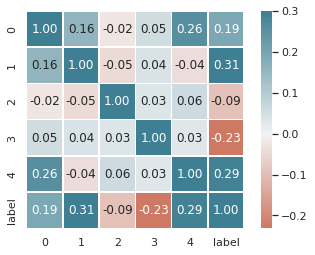

In [21]:
palette = sns.diverging_palette(20, 220, n=256)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=palette, vmax=.3, center=0,
            square=True, linewidths=.5);

The correlation coefficient is defined in the -1 to 1 range. A value close to 0 means there is no correlation. Value of 1 suggests a perfect positive correlation (e.g. as the income increases, your power of expensing are going up, too!). Value of -1 suggests perfect negative correlation (e.g. high number of bad reviews should correlate with lower quality).

Given the heatmap lets just keep the top 4 features

In [23]:
data=data.drop(["2"],axis=1)

##Check Data balance

In [24]:
data["label"].value_counts()

1    7877
2    6990
6    6876
8    6825
4    6824
5    6313
7    3646
0    1726
3    1020
Name: label, dtype: int64

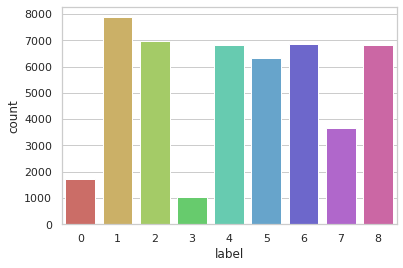

In [25]:
sns.countplot(x='label',data=data, palette='hls')
plt.show()

Data is imbalance

In [26]:
data.groupby("label").mean()

,0,1,3,4
label,,,,
0,1017.379725,-166.995901,-121.300548,-541.199401
1,-843.252761,-427.602921,97.203970,-241.465479
2,97.695979,-316.210522,411.571638,280.871673
3,80.887578,-465.590904,-258.323886,114.534771
4,-65.331448,578.237905,203.623959,130.270692
5,107.544229,-138.631222,-274.340842,-158.020522
6,193.693684,9.160549,527.423492,180.606020
7,-275.316108,578.531756,-208.280487,-228.704822
8,-0.004122,-185.490821,-272.335056,363.935260


##Balancing the data
###SMOTE
The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors

Synthetic samples are generated in the following way: Take the diﬀerence between the feature vector (sample) under consideration and its nearest neighbor. Multiply this diﬀerence by a random number between 0 and 1, and add it to the feature vector under consideration. This causes the selection of a random point along the line segment between two speciﬁc features. This approach eﬀectively forces the decision region of the minority class to become more general.

In [27]:
from imblearn.over_sampling import SMOTE

In [49]:
smt = SMOTE()
Y=data["label"]
X=data.drop(["label"],axis=1)
X, y = smt.fit_resample(X, Y)
y=pd.DataFrame(y)
y.value_counts()

label
0        7877
1        7877
2        7877
3        7877
4        7877
5        7877
6        7877
7        7877
8        7877
dtype: int64

Now it is balanced!

##Normalize features within range 0 (minimum) and 1 (maximum)

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
Xpd = pd.DataFrame(X)

In [45]:
Xpd.describe()

,0,1,2,3
count,70893.000000,70893.000000,70893.000000,70893.000000
mean,0.323901,0.491439,0.493892,0.479139
std,0.171713,0.167875,0.139393,0.155790
min,0.000000,0.000000,0.000000,0.000000
25%,0.205798,0.373979,0.394158,0.372330
50%,0.309244,0.464200,0.495697,0.480671
75%,0.424416,0.599738,0.582408,0.586608
max,1.000000,1.000000,1.000000,1.000000


##preprocess the categorical data
Some Machine Learning algorithms can operate on categorical data without any preprocessing (like Decision trees, Naive Bayes). But most can’t.

Unfortunately, you can’t replace the category names with a number. Converting Label name "1" to 1 and "2" to 2 suggests that "1" is greater (2 times) than "2". That may not be true, specially in case of tokenized data. How can we solve this?

We can use One-hot encoding.
To train the Neural Network, single target column must be converted into one hot encoded format.

In [50]:
from sklearn.preprocessing import OneHotEncoder
Y=OneHotEncoder(sparse=False).fit_transform(y)
# Y=pd.get_dummies(y)
Ypd=pd.DataFrame(Y)
Ypd.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Essentially, we get a vector for each value that contains 1 at the index of the category and 0 for every other value. This encoding solves the comparison issue. The negative part is that your data now might take much more memory.

>for production
All data preprocessing steps are to be performed on the training data and data we’re going to receive via the REST API for prediction. We can unite the steps using make_column_transformer():

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer
transformer = make_column_transformer(
    (MinMaxScaler(), [
      '0','1','3','4'
    ]),
    remainder='drop'
)

In [60]:
test=data.copy()
transformer.fit(test)
test=transformer.transform(test)
test[0]

array([0.34946504, 0.39934576, 0.31137539, 0.46474684])

For Keras, convert dataframe to array values (Inbuilt requirement of Keras)

In [51]:
X = X #already an array
Y = Y #already an array

##Create test/train

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_SEED)

In [70]:
print(X_train.shape,X_test.shape)

(56714, 4) (14179, 4)


#Build our model

Build a Deep Neural Network with Keras

##Error measurement

We’ll use Mean Squared Error which measures the difference between average squared predicted and true values

In [87]:
# First define baseline model. Then use it in Keras Classifier for the training
def baseline_model():
    # Create model here
    model = Sequential()
    model.add(Dense(20, input_shape=[X_train.shape[1]], activation = 'relu')) # Rectified Linear Unit Activation Function
    model.add(Dropout(rate=0.3))
    # model.add(Dense(units=32, activation="relu"))
    # model.add(Dropout(rate=0.5))
    model.add(Dense(9, activation = 'softmax')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'mse', optimizer=adam_v2.Adam(0.0001), metrics = ['mse'])
    # model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

>We also do regularization using Dropout layers.

#Training

We feed the training method with the training data and specify the following parameters:

shuffle - random sort the data
epochs - number of training cycles
validation_split - use some percent of the data for measuring the error and not during training
batch_size - the number of training examples that are fed at a time to our model
callbacks - we use EarlyStopping to prevent our model from overfitting when the training and validation error start to diverge

In [88]:
model=baseline_model()

In [89]:
BATCH_SIZE = 32
early_stop = EarlyStopping(
  monitor='val_mse',
  mode="min",
  patience=10
)
history = model.fit(
  x=X_train,
  y=y_train,
  shuffle=True,
  epochs=100,
  validation_split=0.2,
  batch_size=BATCH_SIZE,
  callbacks=[early_stop]
)

Epoch 1/100
1418/1418 [==============================] - 2s 2ms/step - loss: 0.1858 - mse: 0.1858 - val_loss: 0.1817 - val_mse: 0.1817
Epoch 2/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1774 - mse: 0.1774 - val_loss: 0.1622 - val_mse: 0.1622
Epoch 3/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1674 - mse: 0.1674 - val_loss: 0.1450 - val_mse: 0.1450
Epoch 4/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1580 - mse: 0.1580 - val_loss: 0.1335 - val_mse: 0.1335
Epoch 5/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1508 - mse: 0.1508 - val_loss: 0.1266 - val_mse: 0.1266
Epoch 6/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1454 - mse: 0.1454 - val_loss: 0.1238 - val_mse: 0.1238
Epoch 7/100
1418/1418 [==============================] - 2s 1ms/step - loss: 0.1424 - mse: 0.1424 - val_loss: 0.1221 - val_mse: 0.1221
Epoch 8/100
1418/1418 [==============================] 

#Evaluation

A simple way to understand the training process is to look at the training and validation loss:

In [90]:
def plot_mse(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.plot(hist['epoch'], hist['mse'],
            label='Train MSE')
  plt.plot(hist['epoch'], hist['val_mse'],
            label = 'Val MSE')
  plt.legend()
  plt.show()

We can see a large improvement in the training error. So we are learning!

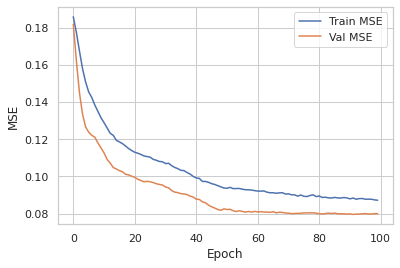

In [91]:
plot_mse(history)

This shows we are really training and on a converging path

#Real test
Recall that we have some additional data. Now it is time to use it and test how good our model. Note that we don’t use that data during the training, only once at the end of the process.

Let’s get the predictions from the model:

In [92]:
y_pred = model.predict(X_test)

In [94]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'R2 {r2_score(y_test, y_pred)}')

MSE 0.07913039394996708
RMSE 0.28130125124138194
R2 0.20135782294506585


Root Mean Squared Error (RMSE) allows us to penalize points further from the mean.

Another statistic we can use to measure how well our predictions fit with the real data is the R^2 score. A value close to 1 indicates a perfect fit.

>There is a huge room for improvement but we leave it for future.

#Saving the model
Now that you have a trained model, you need to store it and be able to reuse it later. Recall that we have a data transformer that needs to be stored, too! Let’s save both:

In [95]:
import joblib
joblib.dump(transformer, "data_transformer.joblib")
model.save("classification_prediction_model.h5")

We can download the files from the notebook using the following:

In [97]:
from google.colab import files
files.download("data_transformer.joblib")
files.download("classification_prediction_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Build REST API

Building a REST API allows us to use your model to make predictions for different clients. Almost any device can speak REST - Android, iOS, Web browsers, and many others.

Flask allows us to build a REST API in just a couple of lines. Of course, we’re talking about a quick-and-dirty prototype. Let’s have a look at the complete code:

In [ ]:
import joblib
import pandas as pd
from flask import Flask, jsonify, request
from tensorflow import keras
app = Flask(__name__)
model = keras.models.load_model("assets/classification_prediction_model.h5")
transformer = joblib.load("assets/data_transformer.joblib")
@app.route("/", methods=["POST"])
def index():
    data = request.json
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(transformer.transform(df))
    predicted_class = prediction.flatten()[0]
    return jsonify({"label": str(predicted_class)})

The API has a single route (index) that accepts only POST requests. Note that we pre-load the data transformer and the model.

The request handler obtains the JSON data and converts it into a Pandas DataFrame. Next, we use the transformer to pre-process the data and get a prediction from our model. Finally we return the predicted class as JSON.

Lets start the server to listen
```
flask run
```

Then ask a prediction
```
curl -d '{"0": "Brooklyn", "1": 123, "2": -123, "3": 123, "4": 123}' -H "Content-Type: application/json" -X POST http://localhost:5000

```



#Deploy to production


We’ll deploy the project to Google App Engine:

Here is the complete app.yaml config:

```
entrypoint: "gunicorn -b :$PORT app:app --timeout 500"
runtime: python
env: flex
service: nyc-price-prediction
runtime_config:
  python_version: 3.7
instance_class: B1
manual_scaling:
  instances: 1
liveness_check:
  path: "/liveness_check"
```

Execute the following command to deploy the project:

```
gcloud app deploy
```

Now our model is deployed and ready for production use.